In [5]:
import pandas as pd
import seaborn as sns
from transformers import  DataCollatorWithPadding
import torch
from transformers import BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import  TrainingArguments, Trainer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, RandomSampler
from tqdm.notebook import trange
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
true = pd.read_csv("/content/drive/My Drive/True.csv")

In [9]:
fake = pd.read_csv("/content/drive/My Drive/Fake.csv")

In [10]:
fake['label'] = 0

In [11]:
true['label'] = 1

In [12]:
df = pd.concat([fake, true]).reset_index(drop=True)
df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


# EDA

In [13]:
missing_values_count = df.isnull().sum() # we get the number of missing data points per column
print("Number of missing data points per column:\n")
print (missing_values_count)

df.dropna(inplace=True) #drop the empty rows


Number of missing data points per column:

title      0
text       0
subject    0
date       0
label      0
dtype: int64


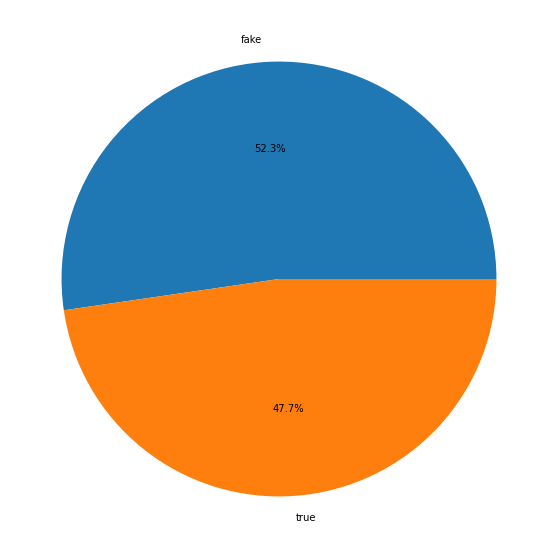

In [14]:
counts = df["label"].value_counts()

class_labels = ["fake", "true"]

counts_per_class = [counts[0], counts[1]]

# counts.plot(kind='barh')

plt.figure(figsize = (10,10))
plt.pie(counts_per_class, labels = class_labels, autopct = '%1.1f%%')
plt.show()

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [16]:
from transformers import pipeline

classifier = pipeline("text-classification",model='distilbert-base-uncased-finetuned-sst-2-english', return_all_scores=False)


In [17]:
dfsample=df.sample(40)

In [18]:
import time
start_time = time.time()
dfsample['text.classification']=dfsample['title'].apply(lambda x:classifier(x))

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.1815457344055176 seconds ---


In [19]:
dfsample['sentiment.label']=dfsample['text.classification'].apply(lambda x:x[0]['label'])
dfsample['sentiment.intensity']=dfsample['text.classification'].apply(lambda x:x[0]['score'])

In [20]:
dfsample

,title,text,subject,date,label,text.classification,sentiment.label,sentiment.intensity
42757,Damaged New Zealand fuel pipeline to be restar...,SYDNEY (Reuters) - A damaged pipeline that res...,worldnews,"September 23, 2017",1,"[{'label': 'NEGATIVE', 'score': 0.999096274375...",NEGATIVE,0.999096
7764,Rich Couple’s INSANE Explanation For Why They...,We know that Donald Trump appeals to what he c...,News,"March 1, 2016",0,"[{'label': 'NEGATIVE', 'score': 0.946623146533...",NEGATIVE,0.946623
9701,TRUMP BEGINS DISMANTLING Of OBAMACARE With Tod...,"Today, President Trump came one step closer to...",politics,"Oct 12, 2017",0,"[{'label': 'POSITIVE', 'score': 0.999806344509...",POSITIVE,0.999806
7725,"This Anti-Gay, Anti-Science Creationist Could...","In the coming days, a creationist conspiracy t...",News,"March 3, 2016",0,"[{'label': 'NEGATIVE', 'score': 0.999456703662...",NEGATIVE,0.999457
18394,TRUMP DRIVES CRITICS CRAZY: Eliminates Obama’s...,"Meanwhile, back at CNN Russia Russia Russia!Th...",left-news,"Jul 2, 2017",0,"[{'label': 'POSITIVE', 'score': 0.864369630813...",POSITIVE,0.864370
44461,"In Athens, Macron to urge renewal of EU democracy",PARIS (Reuters) - French President Emmanuel Ma...,worldnews,"September 5, 2017",1,"[{'label': 'POSITIVE', 'score': 0.996573567390...",POSITIVE,0.996574
22446,RECKLESS: Democratic Party Creating a ‘Russian...,21st Century Wire says The Hillary Clinton cam...,US_News,"October 13, 2016",0,"[{'label': 'NEGATIVE', 'score': 0.990726828575...",NEGATIVE,0.990727
18189,WATCH: RACIST CONGRESSWOMAN MAXINE WATERS Won’...,Close your eyes and picture Speaker of the Hou...,left-news,"Aug 7, 2017",0,"[{'label': 'NEGATIVE', 'score': 0.950760662555...",NEGATIVE,0.950761
43014,Pence tells U.N. that America first does not m...,UNITED NATIONS (Reuters) - President Donald Tr...,worldnews,"September 20, 2017",1,"[{'label': 'NEGATIVE', 'score': 0.991496086120...",NEGATIVE,0.991496
23401,There’s Something Hokey About Ted,"21st Century Wire says At some point, the poli...",Middle-east,"March 21, 2016",0,"[{'label': 'NEGATIVE', 'score': 0.992589831352...",NEGATIVE,0.992590


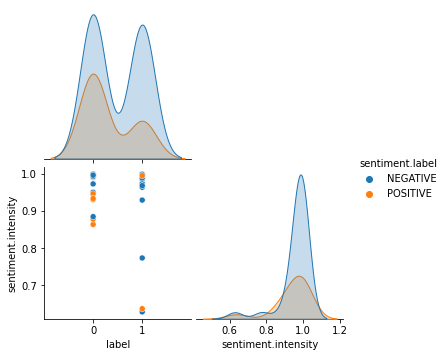

In [21]:
sns.pairplot(dfsample[['label','sentiment.label','sentiment.intensity']], hue="sentiment.label",corner=True)

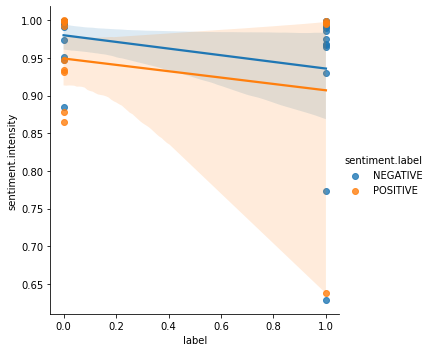

In [22]:
g = sns.lmplot(
    data=dfsample[['label','sentiment.label','sentiment.intensity']],
    x="label", y="sentiment.intensity", hue="sentiment.label",
    height=5
)

In [23]:
df['title.length']=df['title'].apply(lambda x:len(x))

In [24]:
df['text.length']=df['text'].apply(lambda x:len(x))

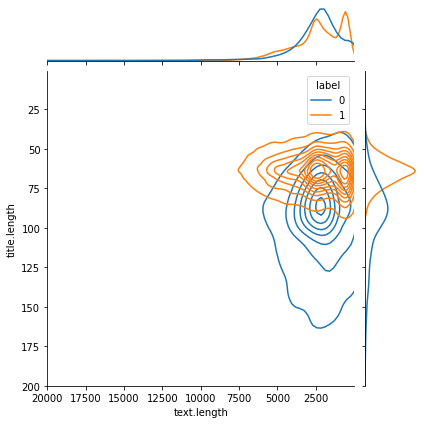

In [25]:
g = sns.jointplot(
    data=df[['label','text.length','title.length']],
    x="text.length", y="title.length", hue="label",xlim=20000,ylim=200,
    kind="kde",
)

In [26]:
import spacy
from spacy_readability import Readability

In [27]:
import en_core_web_sm

In [28]:
import en_core_web_sm
nlp2 = en_core_web_sm.load()
nlp2.add_pipe(Readability())

In [29]:
dfsample2=dfsample.sample(30)

In [30]:
dfsample2['text.nlp']=dfsample2['text'].apply(lambda x:nlp2(x))
dfsample2['title.nlp']=dfsample2['title'].apply(lambda x:nlp2(x))
dfsample2['text.automated_readability_index']=dfsample2['text.nlp'].apply(lambda x:x._.automated_readability_index)
dfsample2['title.automated_readability_index']=dfsample2['title.nlp'].apply(lambda x:x._.automated_readability_index)
dfsample2['text.flesch_kincaid_reading_ease']=dfsample2['text.nlp'].apply(lambda x:x._.flesch_kincaid_reading_ease)
dfsample2['title.flesch_kincaid_reading_ease']=dfsample2['title.nlp'].apply(lambda x:x._.flesch_kincaid_reading_ease)


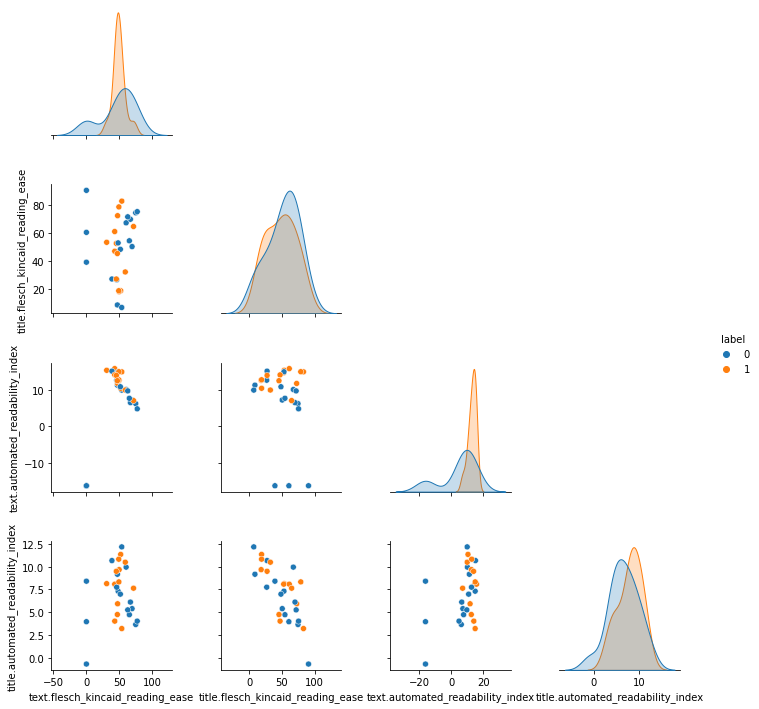

In [31]:
sns.pairplot(dfsample2[['label','text.flesch_kincaid_reading_ease','title.flesch_kincaid_reading_ease','text.automated_readability_index','title.automated_readability_index']], hue="label",corner=True)


In [32]:
dfsample2['title.entities']=dfsample2['title.nlp'].apply(lambda x:[e.label_ for e in x.ents])

In [33]:
dfsample2[dfsample2['label']==0]['title.entities']

22446       [ORG, NORP, ORG]
11419                  [ORG]
18189                     []
11933     [ORG, PERSON, ORG]
8431                [PERSON]
18394             [CARDINAL]
19180          [ORG, PERSON]
5878     [NORP, PERSON, GPE]
7725                      []
20255                  [ORG]
9701          [DATE, PERSON]
15710                  [ORG]
368                       []
6200          [NORP, PERSON]
14602       [NORP, LANGUAGE]
7764                   [ORG]
Name: title.entities, dtype: object

In [34]:
notFakeEntities=pd.DataFrame()
notFakeEntities['entity']=dfsample2[dfsample2['label']==0]['title.entities'].explode()
notFakeEntities['label']=0

In [35]:
FakeEntities=pd.DataFrame()
FakeEntities['entity']=dfsample2[dfsample2['label']==1]['title.entities'].explode()
FakeEntities['label']=1

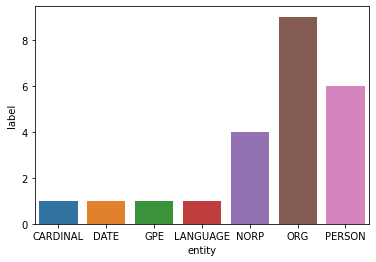

In [36]:
sns.barplot( x='entity',y='label',data=notFakeEntities.groupby('entity').count().reset_index())

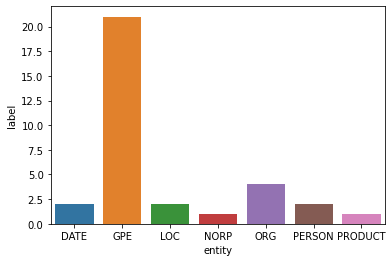

In [37]:
sns.barplot( x='entity',y='label',data=FakeEntities.groupby('entity').count().reset_index())


## Train validation split

In [38]:
train_df, sub_df = train_test_split(df, stratify=df.label.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

validation_df, test_df = train_test_split(sub_df, stratify=sub_df.label.values, 
                                                  random_state=42, 
                                                  test_size=0.25, shuffle=True)


train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Training a fake news classificator

In [39]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name, do_lower_case=True)
batch_size = 16
num_labels = 2
max_len = 30
epochs = 1
learning_rate = 1e-5

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [40]:
def process_data(df, tokenizer, max_len=30):
    """
    Process the data to feed into the pretrained model
    """
    data_processed = tokenizer.batch_encode_plus(df.title.values, pad_to_max_length=True, truncation=True, add_special_tokens=True, return_attention_mask=True, max_length=max_len, return_tensors='pt')
    input_ids_train = data_processed["input_ids"]
    attention_mask_train = data_processed["attention_mask"]
    label_train = torch.tensor(df.label.values)
    return input_ids_train, attention_mask_train, label_train

input_ids_train, attention_mask_train, label_train = process_data(train_df, tokenizer, max_len=max_len)
input_ids_val, attention_mask_val, label_val = process_data(validation_df, tokenizer, max_len=max_len)
input_ids_test, attention_mask_test, label_test = process_data(test_df, tokenizer, max_len=max_len)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [61]:
label_test

tensor([1, 0, 1,  ..., 1, 1, 1])

In [41]:
def load_data(seq, mask, label, batch_size=32, use_train=True):
    """
    Load data into batches
    """
    data = TensorDataset(seq, mask, label)
    if use_train: sampler = RandomSampler(data)
    else: sampler = SequentialSampler(data)
    dl_data = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dl_data

dl_train = load_data(input_ids_train, attention_mask_train, label_train, batch_size=batch_size)
dl_val = load_data(input_ids_val, attention_mask_val, label_val, batch_size=batch_size, use_train=False)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device {}.\n".format(device))

Using device cuda.



In [43]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, output_hidden_states=False, output_attentions=False)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)  

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dl_train) * epochs) #number of batches * number of epochs
# print(model)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [44]:
def eval_metric(predictions, labels):
  ''' Calculate average accuracy of the data samples '''
  max_predictions = predictions.argmax(axis=1, keepdim=True) 
  avg_acc = round(accuracy_score(y_true=labels.to('cpu').tolist(), y_pred=max_predictions.detach().cpu().numpy()), 2)*100 
  return avg_acc

In [45]:
def train_fn(model, train_loader, optimizer, device, scheduler, criterion=None):
  ''' Define the training function '''
  model.train() 
  total_loss, total_acc = 0, 0

  for batch in train_loader:
    batch = tuple(item.to(device) for item in batch)
    input_ids, input_mask, labels = batch
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=input_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item() 
    loss.backward() 
    optimizer.step() 
    scheduler.step()
    logits = outputs.logits
    total_acc += eval_metric(logits, labels)

  loss_per_epoch = total_loss/len(train_loader)
  acc_per_epoch = total_acc/len(train_loader)
  return loss_per_epoch, acc_per_epoch



def eval_fn(model, data_loader, device, criterion=None):
  ''' Define the evaluation function '''
  model.eval() 
  total_loss, total_acc = 0, 0

  with torch.no_grad(): 
    for batch in data_loader:
      batch = tuple(item.to(device) for item in batch)
      input_ids, input_mask, labels = batch
      outputs = model(input_ids, attention_mask=input_mask, labels=labels) 
      loss = outputs.loss
      total_loss += loss.item() 
      logits = outputs.logits
      total_acc += eval_metric(logits, labels)

  loss_per_epoch = total_loss/len(data_loader)
  acc_per_epoch = total_acc/len(data_loader)
  return loss_per_epoch, acc_per_epoch

In [46]:
train_losses, validation_losses = [], [] 
train_accuracies, validation_accuracies = [], []
best_val_loss = float('inf')

for epoch in trange(epochs, desc="Epoch"):
  train_loss_per_epoch, train_acc_per_epoch = train_fn(model, dl_train, optimizer, device, scheduler)
  val_loss_per_epoch, val_acc_per_epoch = eval_fn(model, dl_val, device)

  train_losses.append(train_loss_per_epoch)
  validation_losses.append(val_loss_per_epoch)
  train_accuracies.append(train_acc_per_epoch)
  validation_accuracies.append(val_acc_per_epoch)

  if val_loss_per_epoch < best_val_loss:
    best_val_loss = val_loss_per_epoch
    torch.save(model.state_dict(), 'model.pt')
    
  print("Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(epoch, train_loss_per_epoch, train_acc_per_epoch))
  print("Epoch: {}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%\n".format(epoch, val_loss_per_epoch, val_acc_per_epoch))


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.0853, Train Accuracy: 97.14%
Epoch: 0, Validation Loss: 0.0413, Validation Accuracy: 98.50%



In [62]:
print("Loading the best trained model")
model.load_state_dict(torch.load('model.pt'))

with torch.no_grad():
  input_ids_test = input_ids_test.to(device)
  attention_mask_test = attention_mask_test.to(device)
  outputs = model(input_ids_test, attention_mask_test)
  logits = outputs.logits #output[0] #[batch_size, num_classes]
  batch_logits = logits.detach().cpu().numpy() #shape: [batch_size, num_classes]  
  preds = np.argmax(batch_logits, axis=1)
    

print(classification_report(label_test, preds))
print("ROC AUC Score: {}".format(roc_auc_score(y_true=label_test, y_score=preds)))

Loading the best trained model
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1174
           1       0.97      0.99      0.98      1071

    accuracy                           0.98      2245
   macro avg       0.98      0.98      0.98      2245
weighted avg       0.98      0.98      0.98      2245

ROC AUC Score: 0.9817028458174866


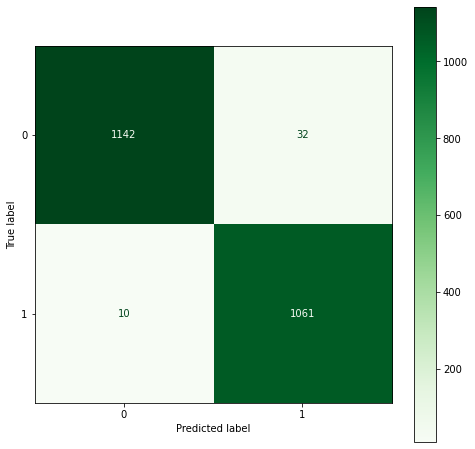

In [63]:
def plot(predictions, labels):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1, 1, 1)
  cm = metrics.confusion_matrix(labels, predictions)
  cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(2))
  cm.plot(values_format='d', cmap='Greens', ax=ax)

plot(preds, label_test)